# Demo and cookbook

In [1]:
import comod
import numpy as np

## Defining a model

In [2]:
model = comod.Model(
    "SIR",  # States
    "bg",  # Coefficients
    [  # Rules in the form (origin, destination, coefficient)
        ("S", "I", "b I / N"),  # N is a special state with the total population
        ("I", "R", "g"),
    ],
    # Special state names can be set with the following options:
    sum_state="N",  # Total population
    nihil_state="$",  # The nothingness (?) from which one is born and to which one dies
)

## Plotting the model

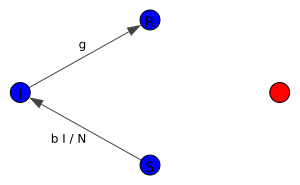

In [3]:
model.plot_graph(layout="circle", bbox=(300, 300 / 1.618))

## Output the differential equations in LaTeX

In [4]:
latex = model.to_latex()
print(latex)

\begin{array}{lcl} \dot{S} &=& -b I / N S\\
\dot{I} &=& b I / N S - g I\\
\dot{R} &=& g I 
\end{array}


In [5]:
from IPython.display import display, Math

display(Math(latex))

<IPython.core.display.Math object>

## Solve and plot

In [6]:
t = np.linspace(0, 150, 150)
S, I, R = model.solve(
    (999, 1, 0),  # Initial state
    [0.3, 0.1],  # Coefficient values
    t,  # Time mesh
    method="RK45",  # see scipy.integrate.solve_ivp
)

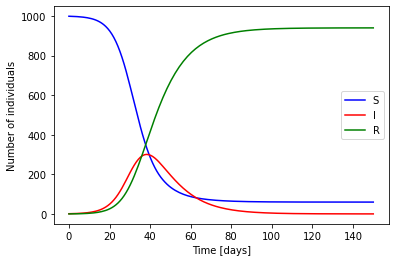

In [7]:
import matplotlib.pyplot as plt

plt.plot(t, S, "b", label="S")
plt.plot(t, I, "r", label="I")
plt.plot(t, R, "g", label="R")
plt.xlabel("Time [days]")
plt.ylabel("Number of individuals")
plt.legend()
plt.show()

### Dynamic solution using ipywidgets

Interactive visualization using ipywidgets. Only available when running as a notebook.

In [8]:
import ipywidgets

In [9]:
@ipywidgets.interact
def plot(
    beta=ipywidgets.FloatSlider(min=0.0, max=2, value=0.3, description="$\\beta$"),
    gamma=ipywidgets.FloatSlider(
        min=0.0, max=0.3, value=0.1, step=0.01, description="$\\gamma$"
    ),
):
    t = np.linspace(0, 150, 150)
    S, I, R = model.solve((999, 1, 0), [beta, gamma], t)
    plt.plot(t, S, "b", label="S")
    plt.plot(t, I, "r", label="I")
    plt.plot(t, R, "g", label="R")
    plt.xlabel("Time [days]")
    plt.ylabel("Number of individuals")
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.3, description='$\\beta$', max=2.0), FloatSlider(value=0.1, descript…

## Time-dependent coefficient solution

In [10]:
def beta_time(t):
    return max(0.1, 0.3 - t / 30 * 0.1)

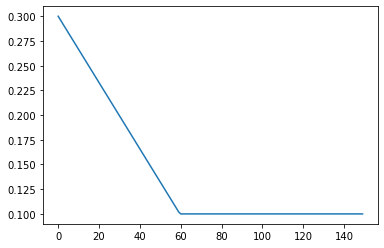

In [11]:
plt.plot([beta_time(x) for x in t])
plt.show()

In [12]:
solution_time = model.solve_time(
    (999, 1, 0),  # Initial state
    [beta_time, lambda x: 0.1],  # Coefficient values
    t,  # Time mesh
)

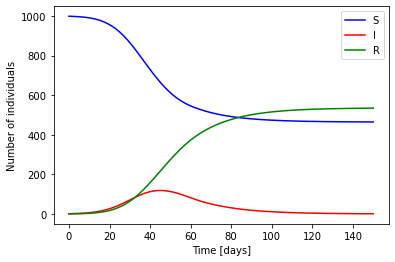

In [13]:
import matplotlib.pyplot as plt

plt.plot(t, solution_time[0], "b", label="S")
plt.plot(t, solution_time[1], "r", label="I")
plt.plot(t, solution_time[2], "g", label="R")
plt.xlabel("Time [days]")
plt.ylabel("Number of individuals")
plt.legend()
plt.show()

## Best fit

Use the previously generated data to best-fit a model.

In [14]:
fit_pars = model.best_fit(
    np.asarray([S, I, R]), t, [0.2, 0.2]  # Existing data  # Time mesh  # Initial guess
).x

print("Fitted parameters:")
for par, value in zip(model.parameters, fit_pars):
    print("%s: %.3f" % (par, value))

Fitted parameters:
b: 0.298
g: 0.101


## Best fit in time windows

Fits can be performed using sliding windows.

First, let's try with the constant model:

In [15]:
results = model.best_sliding_fit(
    np.asarray([S, I, R]),  # Existing data
    t,  # Time mesh
    [0.2, 0.2],  # Initial guess
    window_size=20,  # Window size
    step_size=25,  # Number of time steps between windows
    target="y",  # The target to minimize can be "y" (values) or "dy" (their derivatives)
)
results

,b,g
9.563758,0.300000,0.100001
34.731544,0.300037,0.100028
59.899329,0.301793,0.100076
85.067114,0.298463,0.099781
110.234899,0.299341,0.099746
135.402685,0.299556,0.099773


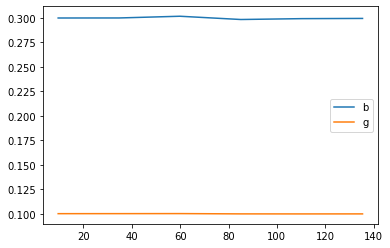

In [16]:
plt.plot(results)
plt.legend(["b", "g"])
plt.show()

Now let's try the time-dependent coefficient model

In [17]:
results = model.best_sliding_fit(
    solution_time,  # Existing data
    t,  # Time mesh
    [0.2, 0.2],  # Initial guess
    window_size=10,  # Window size
    step_size=15,  # Number of time steps between windows
    target="y",  # The target to minimize can be "y" (values) or "dy" (their derivatives)
    time_criterion="mean",  # Determines how a time is assigned to each window in the solution
)
results

,b,g
4.530201,0.288520,0.102111
19.630872,0.238503,0.101901
34.731544,0.188711,0.101453
49.832215,0.138761,0.100800
64.932886,0.098525,0.100100
80.033557,0.099614,0.099815
95.134228,0.099563,0.099749
110.234899,0.100074,0.100113
125.335570,0.100256,0.100254
140.436242,0.099812,0.099812


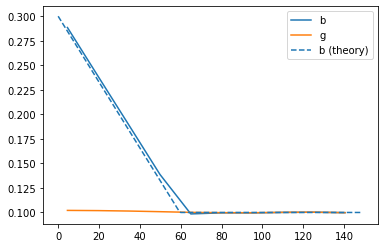

In [18]:
plt.plot(results)
plt.plot([beta_time(x) for x in t], "C0--")
plt.legend(["b", "g", "b (theory)"])
plt.show()